In [4]:
                                            #---- Data warehousing ----#
#                                                 ----------------
#-----
import pandas as pd #reading and writing csv files  
import numpy as np # dealing with arrays 
import seaborn as sns # for advanced graphs 
import matplotlib.pyplot as plt # for traditional graphs 
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')
                                            #---- Machine learning ----#
#                                                 ----------------

# draw matplotlib graphs inline 
%matplotlib inline
sns.set_style("whitegrid") # configuration for seaborn library

In [5]:
orders = pd.read_excel('../ex_retail2_forecasting_data.xlsx')

In [6]:
orders.head()

,Unnamed: 0,InvoiceDate,StockCode,Quantity,TotalPrice,Week,Weekday,Day,UnitPrice
0,0,2009-12-01,10002,12,10.20,49,1,1,0.850000
1,1,2009-12-01,10120,60,12.60,49,1,1,0.210000
2,2,2009-12-01,10125,5,5.10,49,1,1,1.020000
3,3,2009-12-01,10133,23,26.35,49,1,1,1.145652
4,4,2009-12-01,11001,2,6.86,49,1,1,3.430000


In [7]:
orders.drop(['Unnamed: 0'],inplace=True, axis=1)

In [8]:
orders.head()

,InvoiceDate,StockCode,Quantity,TotalPrice,Week,Weekday,Day,UnitPrice
0,2009-12-01,10002,12,10.20,49,1,1,0.850000
1,2009-12-01,10120,60,12.60,49,1,1,0.210000
2,2009-12-01,10125,5,5.10,49,1,1,1.020000
3,2009-12-01,10133,23,26.35,49,1,1,1.145652
4,2009-12-01,11001,2,6.86,49,1,1,3.430000


In [9]:
# Define the feature and target variables
# Split the dataset into train and test dataset

df_train = orders[orders.InvoiceDate<'2011-11-01']
df_test = orders[orders.InvoiceDate>='2011-11-01']

# Based on date and unitPrice the qunaitity will be prediceted
X_train = df_train.drop(labels=['InvoiceDate','StockCode','Quantity','TotalPrice'],axis=1)
y_train = df_train.Quantity

X_test = df_test.drop(labels=['InvoiceDate','StockCode','Quantity','TotalPrice'],axis=1)
y_test = df_test.Quantity

In [10]:
def rmse(y_actual, y_pred):
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    return rmse
rmse_cv = make_scorer(rmse, greater_is_better=False)

In [11]:
# Function to predict on train and test data and return the required metrics
def model_fit(model, X_train, y_train, X_test, y_test):
    ''' 
    Input:
        model = model to be applied
        X_train y_train = Training data
        X_test, y_test = Testing data
    Output:
        rmse for training and test data 
        predicted y for training and test data
    
    '''
#     model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    rmse_train = rmse(y_train, y_train_predict)
    rmse_test = rmse(y_test, y_test_predict)
    
    rmse_all = [rmse_train, rmse_test]
    y_pred_all = [y_train_predict, y_test_predict]
    
    return(rmse_all, y_pred_all)

In [12]:

param_distributions = {'n_estimators': [50,100,500,1000], 'learning_rate':[0.01, 0.05, 0.1],'max_features':['auto'], 'min_samples_leaf':[1, 3, 7, 10], 'min_samples_split':[2,5,10]}
grad_boost = RandomizedSearchCV(GradientBoostingRegressor(random_state=42), param_distributions, verbose=2, n_iter = 100,cv=5, scoring=rmse_cv)
grad_boost.fit(X_train, y_train)


GradientBoostingRegressor(n_estimators=40, random_state=42)

In [13]:
rmse_summary, y_predict_summary = model_fit(grad_boost, X_train, y_train, X_test, y_test)

In [14]:
rmse_summary #train error, test error

[19.160132536584243, 20.939386497864707]

In [15]:
y_predict_summary

[array([18.61734272, 42.72154113, 23.82016333, ..., 15.14692332,
         4.70979624,  4.70979624]),
 array([42.72154113, 15.14692332, 42.72154113, ..., 10.99122602,
         6.59105483, 10.99122602])]

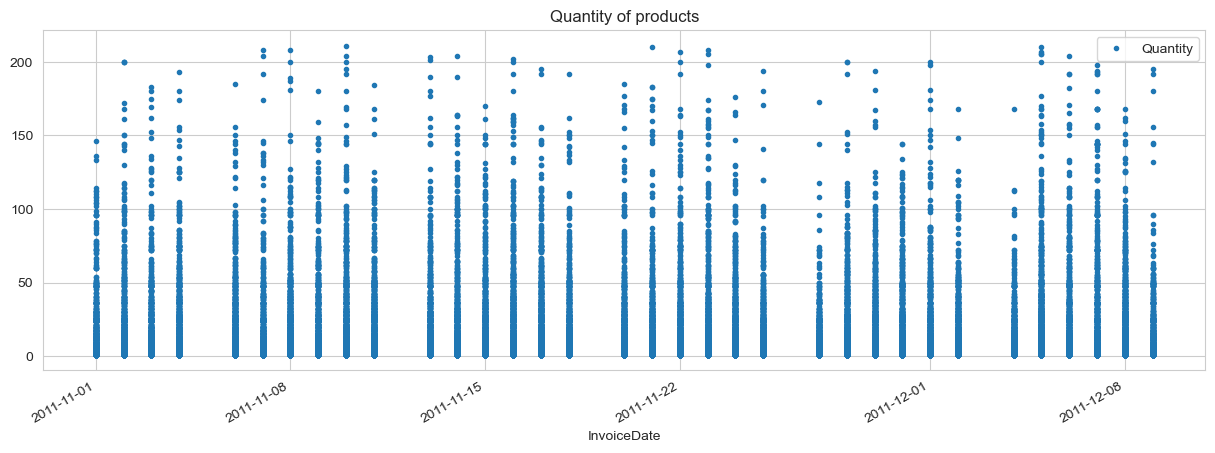

In [16]:
color_pal = sns.color_palette()
orders_df = orders[['InvoiceDate', 'Quantity']]
orders_df.index = pd.to_datetime(orders_df.index)
orders_df = orders_df.set_index('InvoiceDate')
orders_df = orders_df.loc[orders_df.index >= '2011-11-01']
orders_df.plot(style='.',
        figsize=(15, 5),
        color=color_pal,
        title='Quantity of products')
plt.show()

In [17]:
orders_df.index

DatetimeIndex(['2011-11-01', '2011-11-01', '2011-11-01', '2011-11-01',
               '2011-11-01', '2011-11-01', '2011-11-01', '2011-11-01',
               '2011-11-01', '2011-11-01',
               ...
               '2011-12-09', '2011-12-09', '2011-12-09', '2011-12-09',
               '2011-12-09', '2011-12-09', '2011-12-09', '2011-12-09',
               '2011-12-09', '2011-12-09'],
              dtype='datetime64[ns]', name='InvoiceDate', length=43539, freq=None)

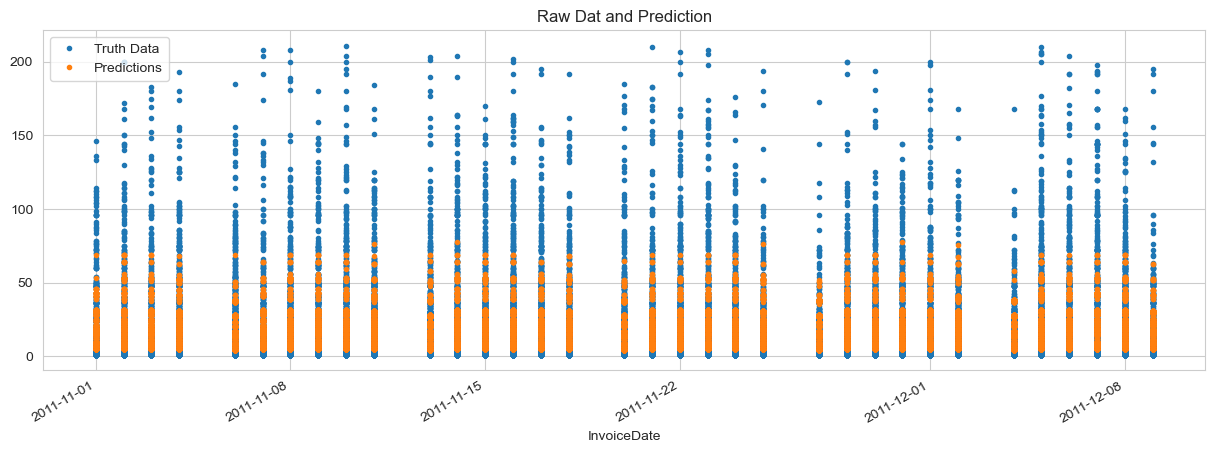

In [18]:
orders_df_pred = orders_df
orders_df_pred['prediction'] = y_predict_summary[1]
ax = orders_df[['Quantity']].plot(figsize=(15, 5), style='.')
orders_df_pred['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

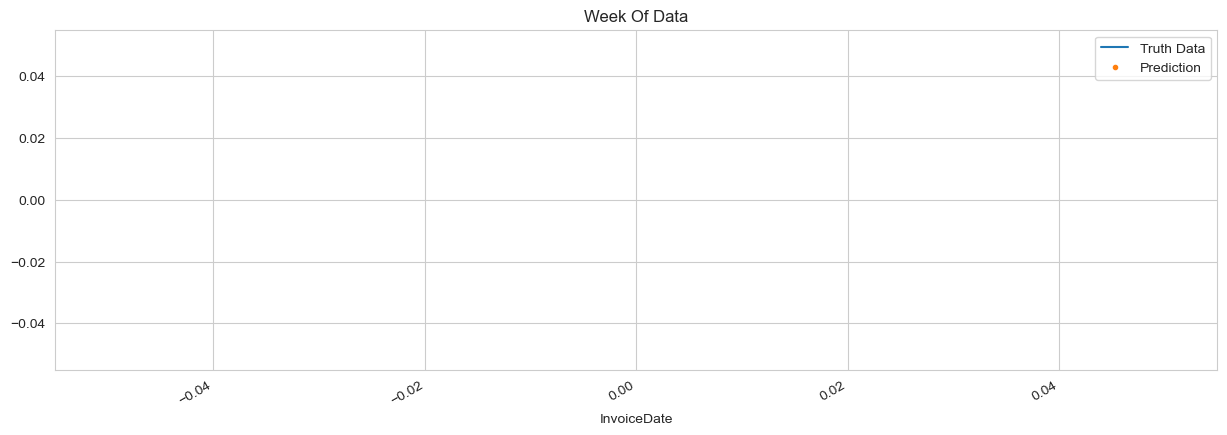

In [19]:
ax = orders_df.loc[(orders_df.index > '04-01-2012') & (orders_df.index < '04-08-2012')]['Quantity'] \
    .plot(figsize=(15, 5), title='Week Of Data')
orders_df_pred.loc[(orders_df_pred.index > '04-01-2012') & (orders_df_pred.index < '04-08-2012')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [20]:
# ax = orders_df.plot(style='.',
#         figsize=(15, 5),
#         color=color_pal,
#         title='Quantity of products')
# orders_df_pred = pd.DataFrame()
# orders_df_pred['InvoiceDate'] = orders_df.index
# orders_df_pred.index = pd.to_datetime(orders_df_pred.index)
# orders_df_pred = orders_df_pred.set_index('InvoiceDate')

# orders_df_pred['prediction'] = y_predict_summary[1]
# orders_df_pred.plot(ax=ax, style='.')
# plt.legend(['Truth Data', 'Predictions'])
# ax.set_title('Raw Dat and Prediction')
# plt.show()